<a href="https://colab.research.google.com/github/link1697/crack_segmentation/blob/main/colab_pytorch_2stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from keras import metrics
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tqdm import tqdm
from keras import backend as K
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [4]:
def ensure_uint8(image):
    if image.dtype != np.uint8:
        image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    # Assuming the input image is a float between 0 and 1
    image = ensure_uint8(image)  # Convert to uint8
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred / 255.0  # Re-normalize to float between 0 and 1 if necessary

def apply_sobel_filter(image, ksize=3):
    # Convert to grayscale
    image = ensure_uint8(image)  # Convert to uint8
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    sobel = cv2.addWeighted(np.absolute(sobelx), 0.5, np.absolute(sobely), 0.5, 0)
    sobel = np.clip(sobel, 0, 255).astype(np.uint8)  # Ensure the result is uint8
    return cv2.cvtColor(sobel, cv2.COLOR_GRAY2BGR) / 255.0  # Convert back to BGR and normalize

def apply_gaussian_noise(image, noise_level=5):
    # Assuming the input image is a float between 0 and 1
    image = ensure_uint8(image)  # Convert to uint8
    gauss_noise = np.random.normal(0, noise_level, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, gauss_noise)
    return noisy_image / 255.0  # Re-normalize to float between 0 and 1 if necessary

def color_distort_smooth(image, hue_shift=87, saturation_scale=1.3, value_scale=1.7):
    # Assuming the input image is a float between 0 and 1
    image = ensure_uint8(image)  # Convert to uint8
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h = (h + hue_shift) % 180
    s = np.clip(s * saturation_scale, 0, 255).astype(np.uint8)
    v = np.clip(v * value_scale, 0, 255).astype(np.uint8)
    final_hsv = cv2.merge((h, s, v))
    color_distorted_image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return color_distorted_image / 255.0  # Re-normalize if necessary

augmentations = [apply_gaussian_blur, apply_sobel_filter, apply_gaussian_noise, color_distort_smooth]

Pre-traning dataset

In [5]:
# Custom Dataset for Crack and Background Pair Loading
class CrackBackgroundDataset(Dataset):
    def __init__(self, crack_dir, background_dir, img_size=(448, 448)):
        self.crack_dir = crack_dir
        self.background_dir = background_dir
        self.img_size = img_size


        # List all files available in the crack directory (assuming they have a matching filename in the background directory)
        self.filenames = [f for f in os.listdir(crack_dir) if os.path.isfile(os.path.join(background_dir, f))]
        np.random.shuffle(self.filenames)
        self.filenames = self.filenames[:960]
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get the filename for this index
        filename = self.filenames[idx]

        # Read crack image and background image
        crack_img_path = os.path.join(self.crack_dir, filename)
        background_img_path = os.path.join(self.background_dir, filename)

        crack_img = cv2.imread(crack_img_path)
        # background_img = cv2.imread(background_img_path)

        # Resize to the desired size
        crack_img = cv2.resize(crack_img, self.img_size) / 255.0
        # background_img = cv2.resize(background_img, self.img_size) / 255.0

        selected_augmentations = random.sample(augmentations, 2)
        crack_left = selected_augmentations[0](crack_img)
        crack_right = selected_augmentations[1](crack_img)
        left_tensor = torch.tensor(crack_left.transpose(2, 0, 1), dtype=torch.float32)
        right_tensor = torch.tensor(crack_right.transpose(2, 0, 1), dtype=torch.float32)

        # selected_augmentations = random.sample(augmentations, 2)
        # background_left = selected_augmentations[1](background_img)
        # background_right = selected_augmentations[0](background_img)
        # left_tensor = torch.tensor(background_left.transpose(2, 0, 1), dtype=torch.float32)
        # right_tensor = torch.tensor(background_right.transpose(2, 0, 1), dtype=torch.float32)
        # Convert to PyTorch tensors and reorder dimensions (channels, height, width)

        return left_tensor, right_tensor


# Set up the device for training and testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define paths and initialize the dataset
crack_dir = "/content/drive/MyDrive/CEE 598 DL/archive/crack_segmentation_dataset/train/images/"
background_dir = "/content/drive/MyDrive/CEE 598 DL/archive/cropped/CFD_background_region/"
img_size = (448, 448)

dataset = CrackBackgroundDataset(crack_dir, background_dir, img_size=img_size)

# Create the DataLoader
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

for crack_batch, background_batch in train_loader:
    # Move batches to the specified device
    crack_batch = crack_batch.to(device)
    background_batch = background_batch.to(device)

    print("Crack Batch Shape (on GPU):", crack_batch.shape)
    print("Background Batch Shape (on GPU):", background_batch.shape)
    break  # Stop after the first batch to inspect

Using device: cuda


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Crack Batch Shape (on GPU): torch.Size([32, 3, 448, 448])
Background Batch Shape (on GPU): torch.Size([32, 3, 448, 448])


U-net + MLP

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# U-Net Encoder Blocks
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# U-Net Encoder Class
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=3, features=32):
        super(UNetEncoder, self).__init__()
        self.enc1 = conv_block(in_channels, features)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = conv_block(features, features * 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = conv_block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = conv_block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck layer
        self.bottleneck = nn.Conv2d(features * 8, features * 16, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.enc1(x)
        x = self.pool1(x)
        x = self.enc2(x)
        x = self.pool2(x)
        x = self.enc3(x)
        x = self.pool3(x)
        x = self.enc4(x)
        x = self.pool4(x)
        x = self.bottleneck(x)

        # Flatten output
        x = x.view(x.size(0), -1)
        return x

# Projection Head Class
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Integrate U-Net Encoder and Projection Head
dummy_input = torch.randn(1, 3, 256, 256).to(device)
encoder = UNetEncoder(in_channels=3, features=32).to(device)
encoder_output = encoder(dummy_input)

# Flattened encoder output size
flattened_output = encoder_output.shape[1]

# Create the projection head with the correct input dimension
projection_head = ProjectionHead(input_dim=flattened_output).to(device)

# Test the forward pass with a dummy input
projected_output = projection_head(encoder_output)
print("Projected Output Shape:", projected_output.shape)


Using device: cuda
Projected Output Shape: torch.Size([1, 64])


train encoder+MLP

In [7]:
# Initialize the encoder and projection head
encoder = UNetEncoder(in_channels=3, features=32)
encoder_output = encoder(torch.randn(1, 3, 448, 448))
flattened_output = encoder_output.shape[1]
projection_head = ProjectionHead(input_dim=flattened_output)

# Set up the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
projection_head.to(device)

# Initialize optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(projection_head.parameters()), lr=0.001)

# Define a contrastive loss class and ensure the loss calculation is on the appropriate device
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, batch_size):
        z1_norm = torch.nn.functional.normalize(z1, dim=1)
        z2_norm = torch.nn.functional.normalize(z2, dim=1)
        similarity_matrix = torch.mm(z1_norm, z2_norm.T) / self.temperature
        labels = torch.arange(batch_size).to(z1.device)
        loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
        return loss

criterion = ContrastiveLoss(temperature=0.1).to(device)

# Training loop for crack-background pairs
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for crack_batch, background_batch in train_loader:
        # Transfer the data to the correct device (GPU or CPU)
        crack_batch, background_batch = crack_batch.to(device), background_batch.to(device)

        # Obtain features and projections for both crack and background images
        crack_features = projection_head(encoder(crack_batch))
        background_features = projection_head(encoder(background_batch))

        # Compute the contrastive loss
        loss = criterion(crack_features, background_features, crack_batch.size(0))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / len(train_loader):.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/100 - Loss: 3.0238
Epoch 2/100 - Loss: 2.8748
Epoch 3/100 - Loss: 2.8741
Epoch 4/100 - Loss: 2.8741
Epoch 5/100 - Loss: 2.8743
Epoch 6/100 - Loss: 2.8739
Epoch 7/100 - Loss: 2.8746
Epoch 8/100 - Loss: 2.8740
Epoch 9/100 - Loss: 2.8747
Epoch 10/100 - Loss: 2.8752
Epoch 11/100 - Loss: 2.8732
Epoch 12/100 - Loss: 2.8719
Epoch 13/100 - Loss: 2.8674
Epoch 14/100 - Loss: 2.8629
Epoch 15/100 - Loss: 2.8867
Epoch 16/100 - Loss: 2.8820
Epoch 17/100 - Loss: 2.8706
Epoch 18/100 - Loss: 2.8660
Epoch 19/100 - Loss: 2.8513
Epoch 20/100 - Loss: 2.8348
Epoch 21/100 - Loss: 2.8095
Epoch 22/100 - Loss: 2.8633
Epoch 23/100 - Loss: 2.9230
Epoch 24/100 - Loss: 2.8748
Epoch 25/100 - Loss: 2.8761
Epoch 26/100 - Loss: 2.8738
Epoch 27/100 - Loss: 2.8750
Epoch 28/100 - Loss: 2.8741
Epoch 29/100 - Loss: 2.8748
Epoch 30/100 - Loss: 2.8743
Epoch 31/100 - Loss: 2.8742
Epoch 32/100 - Loss: 2.8706
Epoch 33/100 - Loss: 2.8743
Epoch 34/100 - Loss: 2.8750
Epoch 35/100 - Loss: 2.8733
Epoch 36/100 - Loss: 2.8670
E

save encoder (for reusing weights and bias in fine-tuning)

In [8]:
# After training with contrastive loss
torch.save(encoder.state_dict(), "/content/drive/MyDrive/CEE 598 DL/pretrained_unet_encoder.pth")

Fine-tuning dataset

In [6]:
# Define a Dataset Class for Crack Images and Masks
class CrackSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # List all image files in the directory (assuming each has a corresponding mask)
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(mask_dir, f))]
        np.random.shuffle(self.image_files)
        self.image_files = self.image_files[:500]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image file name and corresponding mask file path
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        mask_path = os.path.join(self.mask_dir, image_file)  # Assuming masks have the same name

        # Load the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

        # Normalize both to the range [0, 1] without resizing
        image = image / 255.0  # Normalize image
        mask = mask / 255.0  # Normalize mask

        # Convert to PyTorch tensors and change shape to [C, H, W]
        image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add a channel dimension

        return image_tensor, mask_tensor


# Ensure we use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example Usage
# Replace these paths with the appropriate directories containing your crack images and masks
image_dir = "/content/drive/MyDrive/CEE 598 DL/archive/crack_segmentation_dataset/test/images/"
mask_dir = "/content/drive/MyDrive/CEE 598 DL/archive/crack_segmentation_dataset/test/masks/"
dataset = CrackSegmentationDataset(image_dir, mask_dir)

# Check the total size of the dataset
total_size = len(dataset)
train_size = 400
test_size = 100

# Verify that the total matches your desired split
if train_size + test_size != total_size:
    print(f"Warning: Adjusting train/test split to match dataset length ({total_size})")
    train_size = int(0.8 * total_size)  # Example: 60% for training
    test_size = total_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Move batches to the appropriate device (GPU/CPU) for training set
for image_batch, mask_batch in train_loader:
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)
    print("Training Image Batch Shape:", image_batch.shape)
    print("Training Mask Batch Shape:", mask_batch.shape)
    break

# Move batches to the appropriate device (GPU/CPU) for testing set
for image_batch, mask_batch in test_loader:
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)
    print("Testing Image Batch Shape:", image_batch.shape)
    print("Testing Mask Batch Shape:", mask_batch.shape)
    break


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Image Batch Shape: torch.Size([16, 3, 448, 448])
Training Mask Batch Shape: torch.Size([16, 1, 448, 448])
Testing Image Batch Shape: torch.Size([16, 3, 448, 448])
Testing Mask Batch Shape: torch.Size([16, 1, 448, 448])


fine-tuning

用前面unet的encoder

In [7]:

# Residual Block with Debugging
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(ResidualBlock, self).__init__()
        self.projection = None
        if in_channels != num_filters:
            self.projection = nn.Conv2d(in_channels, num_filters, kernel_size=1, stride=1)

        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)

    def forward(self, x):
        #print(f"Input shape to ResidualBlock: {x.shape}")
        shortcut = x
        if self.projection:
            shortcut = self.projection(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        return self.relu(out)

# Attention Gate
class AttentionGate(nn.Module):
    def __init__(self, skip_channels, gate_channels, out_channels):
        super(AttentionGate, self).__init__()
        # Match the number of channels correctly
        self.conv_gate = nn.Conv2d(gate_channels, out_channels, kernel_size=1)
        self.bn_gate = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv_skip = nn.Conv2d(skip_channels, out_channels, kernel_size=1)
        self.bn_skip = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, skip, gate):
        skip_resized = F.interpolate(skip, size=gate.shape[2:], mode='bilinear', align_corners=False)

        # Adjust the gate and skip to have the same dimensions
        gate_resized = self.conv_gate(gate)
        gate_resized = self.bn_gate(gate_resized)
        gate_resized = self.relu(gate_resized)

        skip_resized = self.conv_skip(skip)
        skip_resized = self.bn_skip(skip_resized)

        # Combine the skip and gate tensors
        attention = self.sigmoid(gate_resized + skip_resized)

        # Multiply by the skip tensor
        return skip * attention


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        # Adjust attention gate to receive the correct number of input channels
        self.attention_gate = AttentionGate(skip_channels, out_channels, out_channels)
        # Upsample input channels to expected size
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # Ensure that the residual block receives the correct input channels
        self.residual_block = ResidualBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        #print(f"Shape of x before upconv: {x.shape}")
        x = self.upconv(x)
        #print(f"Shape of x after upconv: {x.shape}")

        # Apply the attention gate to align the skip connection channels
        skip = self.attention_gate(skip, x)
        #print(f"Shape of skip after attention gate: {skip.shape}")

        # Concatenate the skip connection and the upsampled feature map
        x = torch.cat([x, skip], dim=1)
        #print(f"Shape of x after concatenation: {x.shape}")

        # Pass through the residual block
        x = self.residual_block(x)
        #print(f"Shape of x after residual block: {x.shape}")
        return x



# ImprovedUNet Model
class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super(ImprovedUNet, self).__init__()
        self.enc1 = conv_block(in_channels, features)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = conv_block(features, features * 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = conv_block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = conv_block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck layer
        self.bottleneck = nn.Conv2d(features * 8, features * 16, kernel_size=3, padding=1)   #padding =1 keeps feature map height & width unchanged

        self.dec4 = DecoderBlock(features * 16, features * 8, features * 8)
        self.dec3 = DecoderBlock(features * 8, features * 4, features * 4)
        self.dec2 = DecoderBlock(features * 4, features * 2, features * 2)
        self.dec1 = DecoderBlock(features * 2, features, features)

        self.final = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        #print(f"Shape of enc1: {enc1.shape}")
        p1 = self.pool1(enc1)
        enc2 = self.enc2(p1)
        #print(f"Shape of enc2: {enc2.shape}")
        p2 = self.pool2(enc2)
        enc3 = self.enc3(p2)
        #print(f"Shape of enc3: {enc3.shape}")
        p3 = self.pool3(enc3)
        enc4 = self.enc4(p3)
        #print(f"Shape of enc4: {enc4.shape}")
        p4 = self.pool4(enc4)

        bottleneck = self.bottleneck(p4)
        #print(f"Shape of bottleneck: {bottleneck.shape}")  #  expect 512, [batch_size, num_channels, height, width]-[16, 512, 7, 7]

        dec4 = self.dec4(bottleneck, enc4)
        #print(f"Shape of dec4: {dec4.shape}")
        dec3 = self.dec3(dec4, enc3)
        #print(f"Shape of dec3: {dec3.shape}")
        dec2 = self.dec2(dec3, enc2)
        #print(f"Shape of dec2: {dec2.shape}")
        dec1 = self.dec1(dec2, enc1)
        #print(f"Shape of dec1: {dec1.shape}")

        final_output = torch.sigmoid(self.final(dec1))
        #print(f"Shape of final output: {final_output.shape}")
        return final_output



# Model instantiation and device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNet(in_channels=3, out_channels=1, features=32)
model.to(device)


ImprovedUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

fine-tuning train

In [8]:
# Initialize the improved U-Net model
model = ImprovedUNet(in_channels=3, out_channels=1, features=32)

# Load pre-trained weights into the encoder section
pretrained_weights = torch.load( "/content/drive/MyDrive/CEE 598 DL/pretrained_unet_encoder.pth")

# Map pre-trained encoder weights to fine-tuning model's encoder layers
model_state = model.state_dict()

# Adjust this mapping according to your encoder's specific layer names
encoder_weights_mapping = {
    'enc1.0.weight': 'enc1.conv.weight',
    'enc1.0.bias': 'enc1.conv.bias',
    'enc2.0.weight': 'enc2.conv.weight',
    'enc2.0.bias': 'enc2.conv.bias',
    'enc3.0.weight': 'enc3.conv.weight',
    'enc3.0.bias': 'enc3.conv.bias',
    'enc4.0.weight': 'enc4.conv.weight',
    'enc4.0.bias': 'enc4.conv.bias',
}

# Update the model's state dictionary with the pre-trained weights
for pre_key, fine_key in encoder_weights_mapping.items():
    if pre_key in pretrained_weights and fine_key in model_state:
        model_state[fine_key] = pretrained_weights[pre_key]

# Load the updated state dictionary back into the model
model.load_state_dict(model_state)

for name, param in model.named_parameters():
    if name in encoder_weights_mapping.values():
        param.requires_grad = False

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            # Move images and masks to the GPU
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / len(train_loader):.4f}")

# Testing/Prediction function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    masks = []
    with torch.no_grad():
        for images, gt in test_loader:
            # Move images to the GPU
            images = images.to(device)
            outputs = model(images)

            # Apply thresholding to get binary predictions
            # predicted_masks = (outputs > 0.5).float()

            # Store predictions (back to CPU if necessary)
            predictions.extend(outputs.cpu())
            masks .extend(gt.cpu())


    return predictions, masks

# Define a loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Example usage
# Fine-tune the model
num_epochs = 200  # Adjust as needed
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model on the test dataset
predicted_masks, origin_masks = evaluate_model(model, test_loader)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/200 - Loss: 0.2941
Epoch 2/200 - Loss: 0.1120
Epoch 3/200 - Loss: 0.1036
Epoch 4/200 - Loss: 0.0999
Epoch 5/200 - Loss: 0.0985
Epoch 6/200 - Loss: 0.0962
Epoch 7/200 - Loss: 0.0911
Epoch 8/200 - Loss: 0.0890
Epoch 9/200 - Loss: 0.0865
Epoch 10/200 - Loss: 0.0807
Epoch 11/200 - Loss: 0.0796
Epoch 12/200 - Loss: 0.0810
Epoch 13/200 - Loss: 0.0738
Epoch 14/200 - Loss: 0.0763
Epoch 15/200 - Loss: 0.0715
Epoch 16/200 - Loss: 0.0788
Epoch 17/200 - Loss: 0.0752
Epoch 18/200 - Loss: 0.0714
Epoch 19/200 - Loss: 0.0689
Epoch 20/200 - Loss: 0.0688
Epoch 21/200 - Loss: 0.0703
Epoch 22/200 - Loss: 0.0679
Epoch 23/200 - Loss: 0.0693
Epoch 24/200 - Loss: 0.0675
Epoch 25/200 - Loss: 0.0652
Epoch 26/200 - Loss: 0.0611
Epoch 27/200 - Loss: 0.0626
Epoch 28/200 - Loss: 0.0608
Epoch 29/200 - Loss: 0.0632
Epoch 30/200 - Loss: 0.0599
Epoch 31/200 - Loss: 0.0594
Epoch 32/200 - Loss: 0.0586
Epoch 33/200 - Loss: 0.0596
Epoch 34/200 - Loss: 0.0574
Epoch 35/200 - Loss: 0.0588
Epoch 36/200 - Loss: 0.0584
E

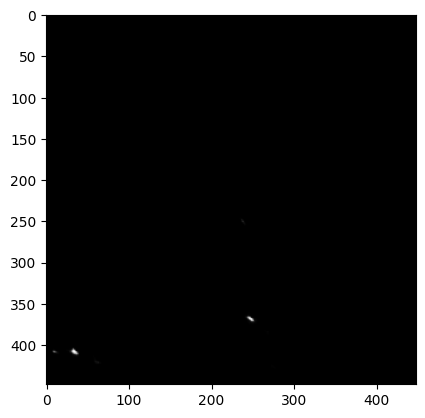

In [18]:
plt.imshow(predicted_masks[29][0], cmap='gray')
torch.save(model, '/content/drive/MyDrive/CEE 598 DL/2stage_model_2.pth')

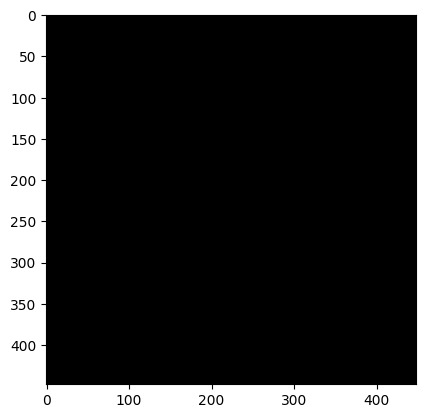

In [16]:
plt.imshow(origin_masks[29][0], cmap='gray')

In [ ]:
plt.imshow(origin_masks[30][0], cmap='gray')
np.sum(origin_masks)

In [ ]:
import os
os.kill(os.getpid(), 9)

improved unet for fine tuning?

encoder + MLP?

contrastive_loss